## Table of Contents:

### 1. [Required Libraries](#Libraries)

### 2. [Outliers Treatment class](#outliers)

### 3. [Example how to use it](#ex1)

### 4. [Another Example how to use it](#ex2)

### 1. [Required Libraries](#Libraries)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

### 2. [Outliers Treatment class](#outliers)

In [2]:
class OutliersTreatment:
    """
        Treat with numerical outliers for each column in the DataFrame.

        Using two type of methods to determine the ouliers (iqr, z_score) dependeing on if the data is normally distributed or not.

        normally distributed => z_score
        skewed distribution => iqr

        Args:
            data    : The whole dataframe.
            columns : Selected columns in the dataframe.

        Functions:
            iqr and z_socre : calculate the min and max cutoff thresholds.
            fit: perform the outliers indices in the dataframe.
            transorm: transform the old data to new one (after removing outliers).
            plot: plot box plot for old and new data, also plot the distribution of the data before removing the data.
    """
    def __init__(
        self, 
        data: pd.DataFrame,
        columns: list = [],
    ):
        # defining the input data
        self.data = data
        # determine only the numerical columns
        self._numerical_columns = data[columns if not pd.Index(columns).empty else data.columns].select_dtypes(include=np.number).columns
        
        # check for numerical columns
        assert not self._numerical_columns.empty, "There is no numerical data in the selected columns" 
        
        # p-value(normal test) for each column
        self._normal_tests = stats.normaltest(data[self._numerical_columns])[1]
        
    @staticmethod
    def iqr(col_data):
        q1, q3 = col_data.quantile([0.25, 0.75])
        iqr = q3 - q1
        return q1 - 1.5 * iqr, q3 + 1.5 * iqr, col_data # min_threshold, max_threshold, new_data_col
    
    @staticmethod
    def z_score(col_data):
        return -3, 3, pd.Series(stats.zscore(col_data)) # min_threshold, max_threshold
    
    def fit(self):
        self.outliers_indices_ = pd.Index([])
        
        for indx, col in enumerate(self._numerical_columns):
            # normal distribution test to choose which method iqr or zscore
            outlier_method = self.z_score if self._normal_tests[indx] >= .05 else self.iqr
            
            min_thd, max_thd, new_data_col =  outlier_method(self.data[col])
            
            indices = new_data_col[(new_data_col < min_thd) | (new_data_col > max_thd)].index
            
            self.outliers_indices_ = self.outliers_indices_.union(indices)
            
        return self.outliers_indices_
            
    def transform(self):
        assert hasattr(self, "outliers_indices_"), "You should perform the fit function first" # make sure that fit is implemented
        
        self.new_data = self.data.drop(index=self.outliers_indices_).reset_index(drop=True)
        return self.new_data
    
    def plot(self):
        assert hasattr(self, "new_data"), "You should perform the fit & transform functions first" #make sure that fit and transform are implemented
        
        fig = plt.figure(figsize=(25, 30))
        fig.suptitle("Outliers Statistics")
        fig.subplots_adjust(hspace=0.5)
        sns.set_theme(style="whitegrid", palette="pastel")
        
        subfigs = fig.subfigures(len(self._numerical_columns), 1)

        for indx, col in enumerate(self._numerical_columns):
            subfigs[indx].suptitle(f"Outliers for {col} column")
                
            (ax1, ax2, ax3) = subfigs[indx].subplots(1, 3)
            
            sns.boxplot(data=self.data, x=col, ax=ax1) # before removing outliers
            sns.boxplot(data=self.new_data, x=col, ax=ax2) # after removing outliers
            sns.histplot(self.data[col], kde=True, ax=ax3) # data distribution before removing outliers
            
            subfigs[indx].subplots_adjust(bottom=0.25, right=0.8, top=0.75)

            ax1.set_title("before removing outliers")
            ax2.set_title("after removing outliers")
            ax3.set_title(f"data distribution before removing outliers")
            ax3.set_xlabel(f"{col} ({'Noraml Distribution' if self._normal_tests[indx] >= .05 else 'Skewed Distribution'})")

### 3. [Example how to use it](#ex1)

In [3]:
df = pd.read_csv("Datasets/diabetes.csv")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
model = OutliersTreatment(df, columns=df.columns[:-1])

In [5]:
model.fit() # return the ouliers indices in DataFrame

Index([  4,   7,   8,   9,  12,  13,  15,  18,  39,  43,
       ...
       684, 691, 695, 697, 703, 706, 707, 710, 715, 753],
      dtype='object', length=129)

In [6]:
model.transform() # return the new DataFrame after removing outliers

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
634,10,101,76,48,180,32.9,0.171,63,0
635,2,122,70,27,0,36.8,0.340,27,0
636,5,121,72,23,112,26.2,0.245,30,0
637,1,126,60,0,0,30.1,0.349,47,1


In [7]:
model._normal_tests

array([3.91429164e-18, 2.04465070e-03, 3.78012708e-67, 1.71241577e-04,
       6.89534274e-85, 1.96968695e-19, 1.29876975e-70, 9.30898004e-27])

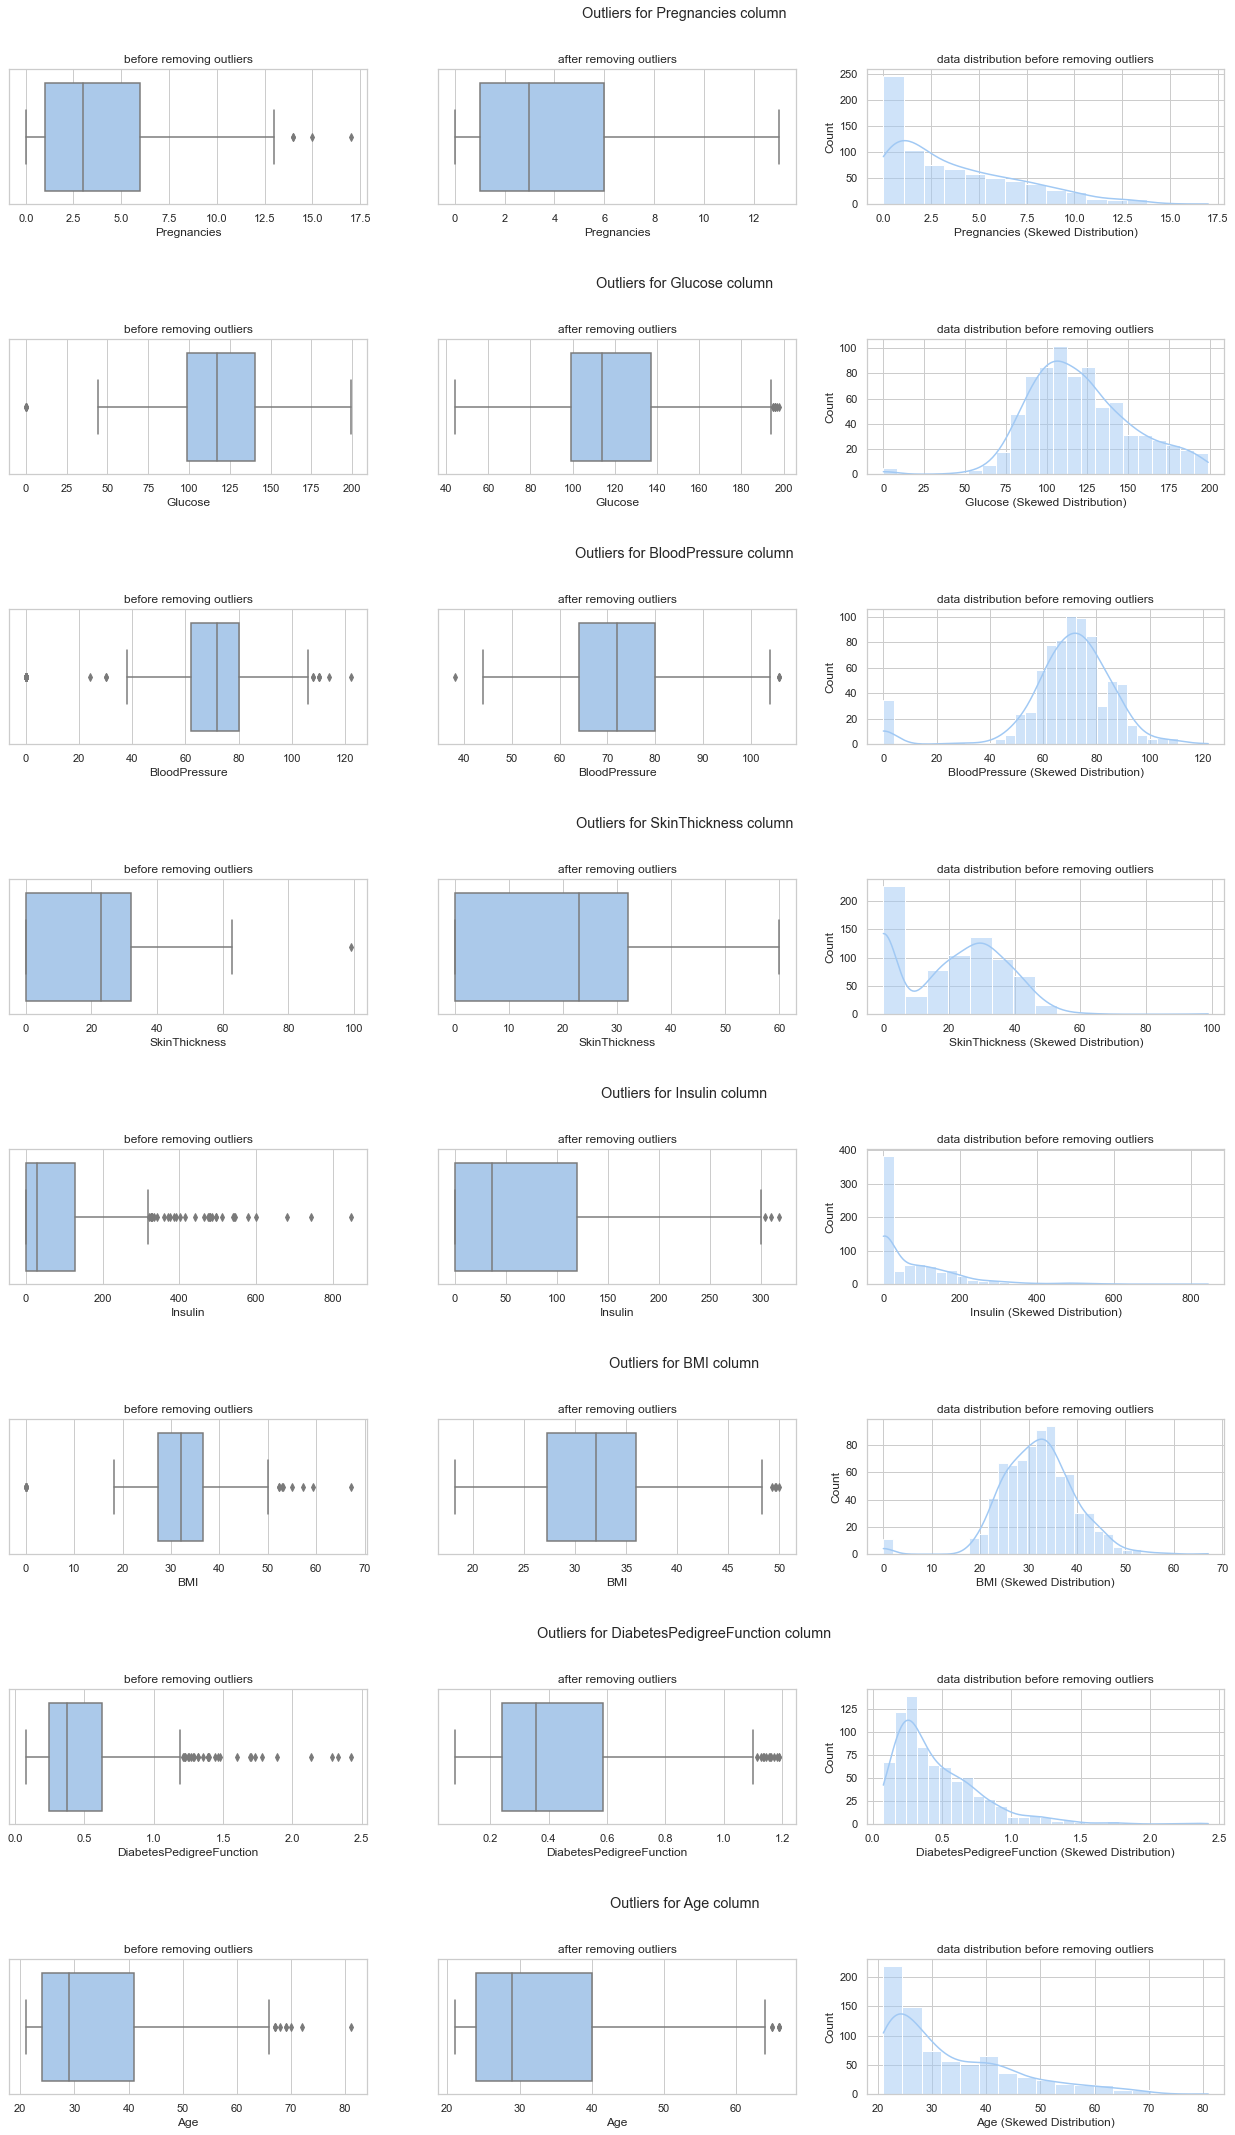

In [8]:
model.plot()

### 4. [Another Example how to use it](#ex2)

In [9]:
df2 = pd.read_csv("Datasets/heart.csv")

df2.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [10]:
model2 = OutliersTreatment(df2, columns=["age", "chol", "thalachh", "oldpeak"])

In [11]:
model2.fit() # return the ouliers indices in DataFrame

Index([28, 85, 96, 101, 204, 220, 221, 246, 250, 272, 291], dtype='object')

In [12]:
model2.transform() # return the new DataFrame after removing outliers

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
288,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
289,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
290,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [13]:
model2._normal_tests

array([1.26008261e-02, 7.36886920e-19, 1.19052434e-03, 3.41677579e-15])

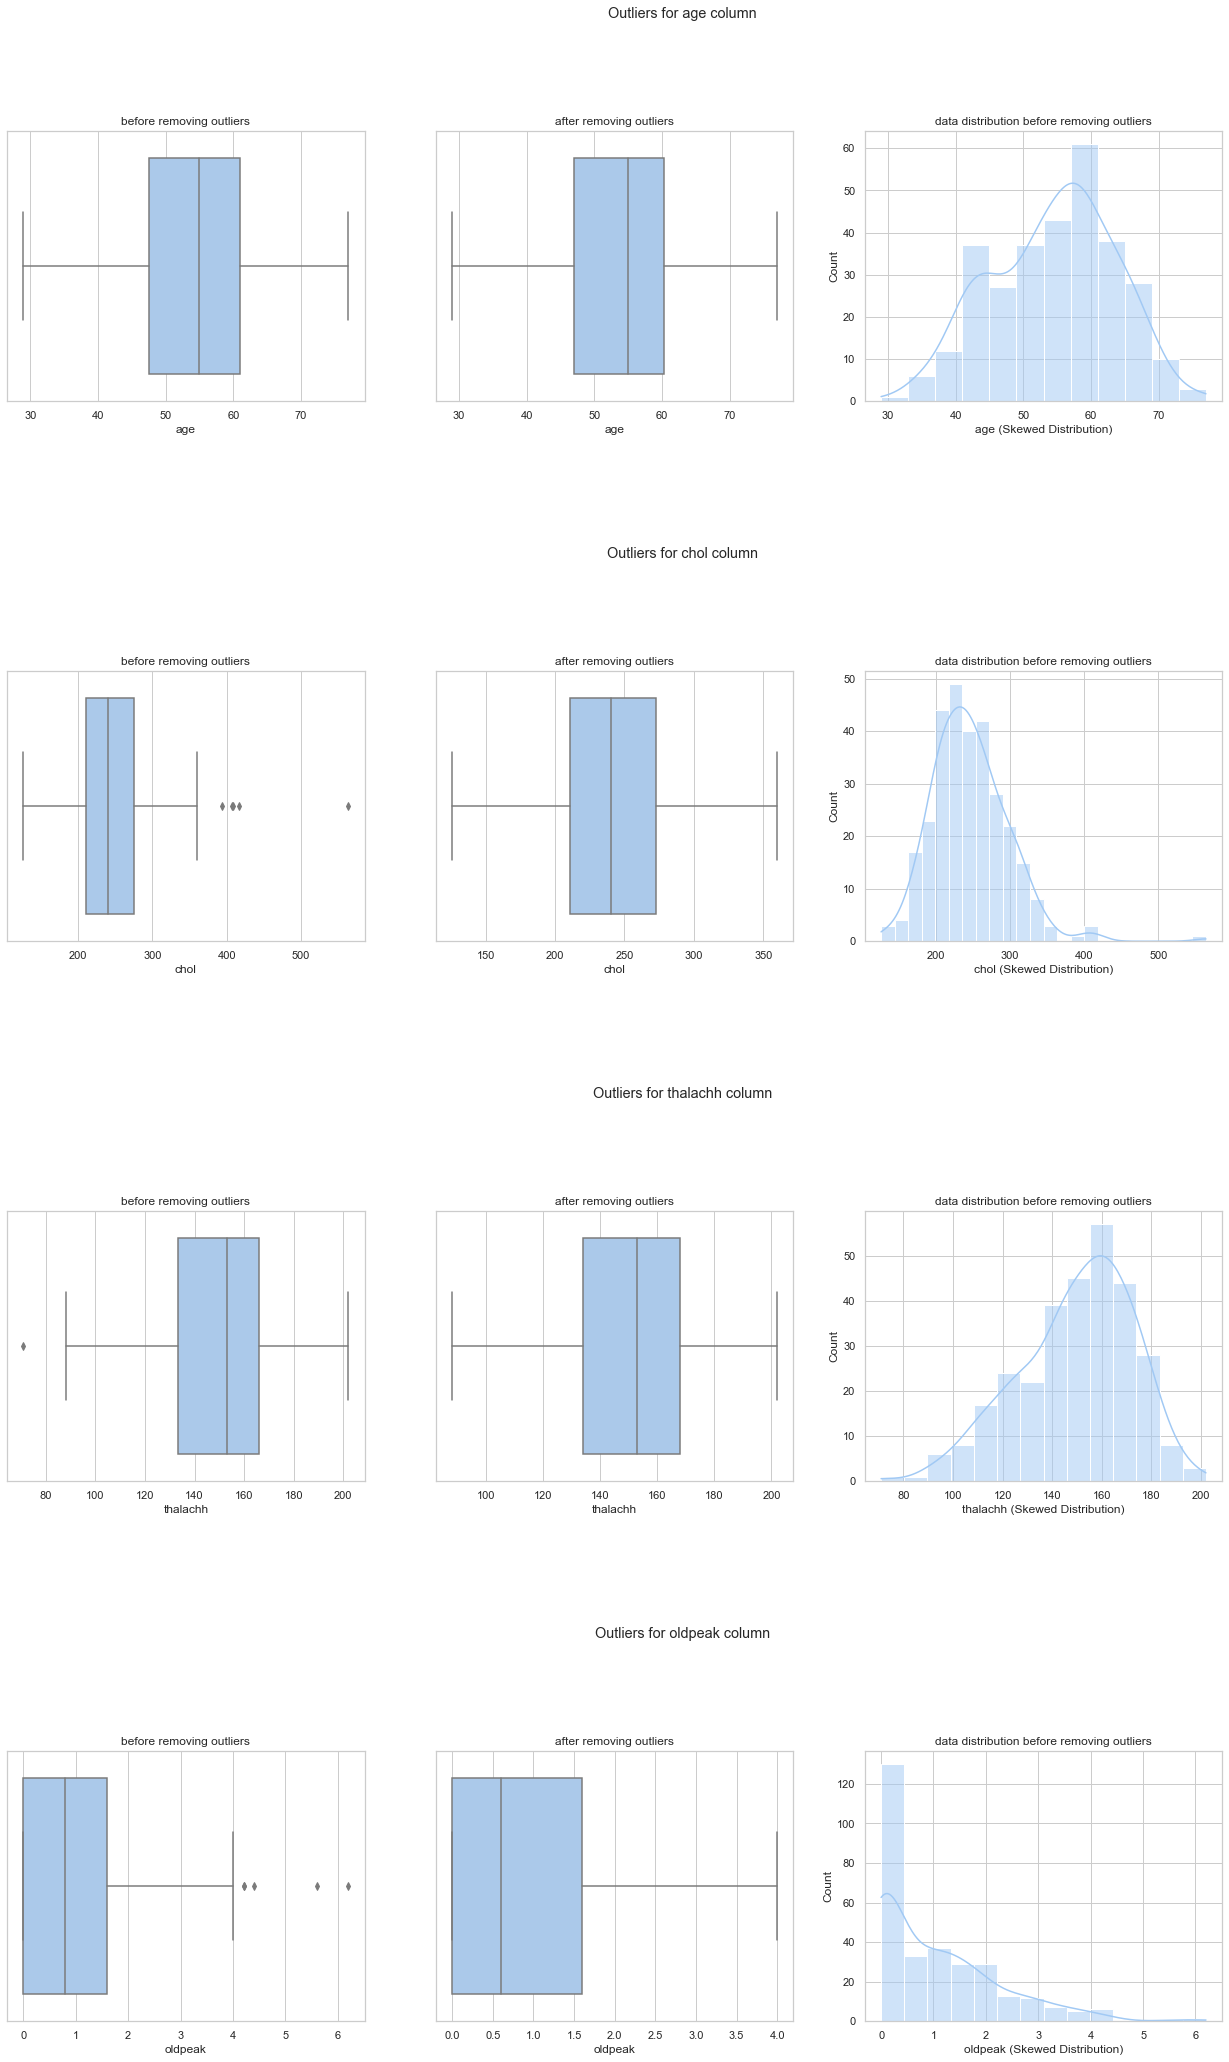

In [14]:
model2.plot()